
# Multi‑Maturity Calibration Demo (AAPL)

*This notebook shows an end‑to‑end workflow to calibrate three models across **multiple option maturities**:*

- **Heston** (semi‑analytic CF; fast & smooth objective)  
- **rBergomi** (rough volatility; Monte Carlo)  
- **Rough Heston** (rough volatility + mean reversion; Monte Carlo)

We will:

1. **Download real AAPL option data** with `yfinance`.
2. For a set of target tenors (e.g., 1m/3m/6m/1y), pick the **closest available expiries**.
3. **Infer** risk‑free `r` and dividend yield `q` from **put–call parity regression** per expiry.
4. Build one **clean call smile per expiry** (parity‑cleaned mids), then
5. Perform **joint calibration across maturities** for each model.
6. **Plot** the fitted smiles and report **global RMSEs** in price‑ and IV‑space.

> **Why multi‑maturity?**  
> Rough models shine when you fit *several maturities* (term structure of skew/forward variance).  
> For a single maturity, classic Heston often wins on both **speed** and **fit** because it uses a semi‑analytic characteristic function (smooth objective) while rough models are Monte Carlo (noisy & slower).



## 1) Environment setup & helper functions

*Notes:*
- We assume this notebook lives in `notebooks/` and the project root is one level up, so we append it to `sys.path`.
- We provide small **IV helpers** that map `(S,r,q)` to a **no‑dividend equivalent** via `S_eff = S e^{-qT}`, `r_eff = r-q` so we can reuse your `implied_volatility` solver.
- A tiny **calibration cache** (JSON) is included so repeated runs are instant.


In [44]:
import os, sys, math, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- project path ---
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if repo_root not in sys.path:
    sys.path.append(repo_root)

# --- project imports ---
from src.black_scholes import black_scholes_price
from src.volatility import implied_volatility
from src.heston import heston_price
from src.rough import rbergomi_paths, rough_heston_paths
from src.calibration import calibrate_rbergomi, calibrate_rough_heston, calibrate_cached, calibrate_heston_cached

plt.rcParams["figure.figsize"] = (12,4)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11

# --- IV helpers ---
def implied_vol_q(price, S, K, T, r, q, option_type="call"):
    Seff = S * math.exp(-q*T)
    reff = r - q
    return implied_volatility(price, Seff, K, T, reff, option_type=option_type)

def prices_to_ivs(S, r, q, T, strikes, prices, option_type="call"):
    ivs = []
    for K, p in zip(strikes, prices):
        try:
            ivs.append(implied_vol_q(p, S, K, T, r, q, option_type))
        except Exception:
            ivs.append(np.nan)
    return np.array(ivs, float)

WING_BOOST_ALPHA = 0.3
WORKERS = 12

In [45]:

# --- calibration cache wrappers ---
try:
    from src.calibration import calibrate_cached
except (ImportError, AttributeError):
    import importlib, src.rough as _rough
    importlib.reload(_rough)
    import src.calibration as _cal
    _cal = importlib.reload(_cal)
    calibrate_cached = _cal.calibrate_cached

CACHE_DIR = os.path.abspath(os.path.join(repo_root, "cache"))
os.makedirs(CACHE_DIR, exist_ok=True)

def _cache_overrides():
    import os
    n_workers = WORKERS if "WORKERS" in globals() else (min(12, os.cpu_count() or 12))
    par_backend = PAR_BACKEND if "PAR_BACKEND" in globals() else "thread"
    terminal = TERMINAL_ONLY if "TERMINAL_ONLY" in globals() else True
    wing = WING_BOOST_ALPHA if "WING_BOOST_ALPHA" in globals() else 0.2
    return dict(n_workers=n_workers, parallel_backend=par_backend, terminal_only=terminal, wing_boost_alpha=wing)
def calibrate_rbergomi_cached(smiles, metric, vega_weight, x0, mc, seed=1234,
                              bounds=None, multistart=2, options=None):
    overrides = _cache_overrides()
    overrides["parallel_backend"] = "process"  # RB uses processes for speed
    return calibrate_cached(
        "rbergomi", calibrate_rbergomi,
        smiles=smiles, metric=metric, vega_weight=vega_weight, x0=x0, mc=mc,
        seed=seed, bounds=bounds, multistart=multistart, options=options,
        cache_dir=CACHE_DIR, runtime_overrides=overrides,
    )

def calibrate_rough_heston_cached(smiles, metric, vega_weight, x0, mc, seed=7777,
                                  bounds=None, multistart=2, options=None):
    overrides = _cache_overrides()
    # Rough Heston prefers threads to reuse numba JIT
    return calibrate_cached(
        "rough_heston", calibrate_rough_heston,
        smiles=smiles, metric=metric, vega_weight=vega_weight, x0=x0, mc=mc,
        seed=seed, bounds=bounds, multistart=multistart, options=options,
        cache_dir=CACHE_DIR, runtime_overrides=overrides,
    )



## 2) Pull AAPL option data and build one smile per expiry

**Steps**
1. Choose target tenors (e.g., 1m/3m/6m/1y) and find the **closest available** expiries from Yahoo.
2. For each expiry:
   * compute **T** in years,
   * infer **DF** and **F** from `C-P = DF*(F-K)` (OLS regression),
   * recover **r** and **q**, and
   * build a **parity-cleaned call smile** `C = P + DF*(F-K)`.


In [46]:
import datetime as dt
import yfinance as yf

ticker = 'AAPL'
tk = yf.Ticker(ticker)
target_days = [30, 90, 180, 365]
avail = tk.options
if not avail: raise RuntimeError('No option expiries available from yfinance.')

def _closest_expiry(days):
    today = dt.date.today()
    tgt = today + dt.timedelta(days=days)
    return min(avail, key=lambda s: abs(dt.datetime.strptime(s, '%Y-%m-%d').date() - tgt))

expiries = []
seen = set()
for d in target_days:
    e = _closest_expiry(d)
    if e not in seen:
        expiries.append(e); seen.add(e)
print('Chosen expiries:', expiries)

hist = tk.history(period='1d')
if hist.empty: raise RuntimeError(f'No spot history for {ticker}.')
S0 = float(hist['Close'].iloc[-1])

def _mid(df, use_last=True):
    bid = pd.to_numeric(df['bid'], errors='coerce')
    ask = pd.to_numeric(df['ask'], errors='coerce')
    mid = 0.5*(bid+ask)
    if use_last:
        last = pd.to_numeric(df.get('lastPrice', np.nan), errors='coerce')
        fill = (~np.isfinite(mid)) | (mid<=0)
        in_spread = (last>= (bid-1e-8)) & (last<= (ask+1e-8))
        mid[fill & in_spread] = last[fill & in_spread]
    return mid

def build_smile_for_expiry(tk, expiry, S0, moneyness_window=0.25, thin_to=14):
    chain = tk.option_chain(expiry)
    calls, puts = chain.calls.copy(), chain.puts.copy()
    calls['mid'] = _mid(calls)
    puts['mid']  = _mid(puts)
    tab = pd.merge(calls[['strike','mid']].rename(columns={'mid':'Cmid'}),
                   puts[['strike','mid']].rename(columns={'mid':'Pmid'}), on='strike', how='inner').dropna()
    # focus around spot
    tab = tab[(tab['strike'] > (1-moneyness_window)*S0) & (tab['strike'] < (1+moneyness_window)*S0)]
    tab = tab.sort_values('strike').reset_index(drop=True)
    if thin_to and len(tab) > thin_to:
        step = max(1, len(tab)//thin_to); tab = tab.iloc[::step].reset_index(drop=True)
    if tab.empty: return None
    K = tab['strike'].to_numpy(float); C = tab['Cmid'].to_numpy(float); P = tab['Pmid'].to_numpy(float)
    # simple parity regression C-P = DF*(F-K) = a + b*K
    y = C - P; X = np.vstack([np.ones_like(K), K]).T
    try:
        coeffs, *_ = np.linalg.lstsq(X, y, rcond=None)
        a, b = coeffs; DF = float(max(1e-10, -b)); F = float(a/DF)
        T = max(1e-6, (pd.to_datetime(expiry) - pd.Timestamp.today()).days/365.0)
        r = -np.log(DF)/T; q = r - np.log(max(F,1e-12)/max(S0,1e-12))/T
    except Exception:
        T = max(1e-6, (pd.to_datetime(expiry) - pd.Timestamp.today()).days/365.0); r, q = 0.02, 0.0
    strikes = K; mids = C
    if strikes.size == 0 or np.all(~np.isfinite(mids)): return None
    return dict(S0=S0, r=float(r), q=float(q), T=T, strikes=strikes, mids=mids, cp='call', expiry=expiry)



Chosen expiries: ['2025-11-21', '2026-01-16', '2026-04-17', '2026-09-18']


In [47]:

# Assemble smiles and clean invalid strikes
smiles = []
for e in expiries:
    smile = build_smile_for_expiry(tk, e, S0)
    if smile is None:
        continue
    smiles.append(smile)

if not smiles:
    raise RuntimeError("No valid smiles retrieved")

def _clean_smile(sm):
    strikes = np.array(sm["strikes"], float)
    mids = np.array(sm["mids"], float)
    mask = np.isfinite(mids) & np.isfinite(strikes) & (mids > 0)
    strikes = strikes[mask]
    mids = mids[mask]
    if strikes.size < 2:
        return None
    mkt_iv = prices_to_ivs(sm["S0"], sm["r"], sm["q"], sm["T"], strikes, mids, "call")
    if np.any(~np.isfinite(mkt_iv)):
        good = np.isfinite(mkt_iv) & (mkt_iv > 0)
        strikes = strikes[good]
        mids = mids[good]
        if strikes.size < 2:
            return None
    return strikes, mids

clean_smiles = []
smiles_list = []
for sm in smiles:
    cleaned = _clean_smile(sm)
    if cleaned is None:
        print("[skip] {} insufficient clean data".format(sm["expiry"]))
        continue
    strikes, mids = cleaned
    clean_sm = dict(sm)
    clean_sm["strikes"] = strikes
    clean_sm["mids"] = mids
    clean_smiles.append(clean_sm)
    smiles_list.append((sm["S0"], sm["r"], sm["q"], sm["T"], strikes, mids, sm["cp"]))

if not smiles_list:
    raise RuntimeError("No valid smiles remain after cleaning")

smiles = clean_smiles


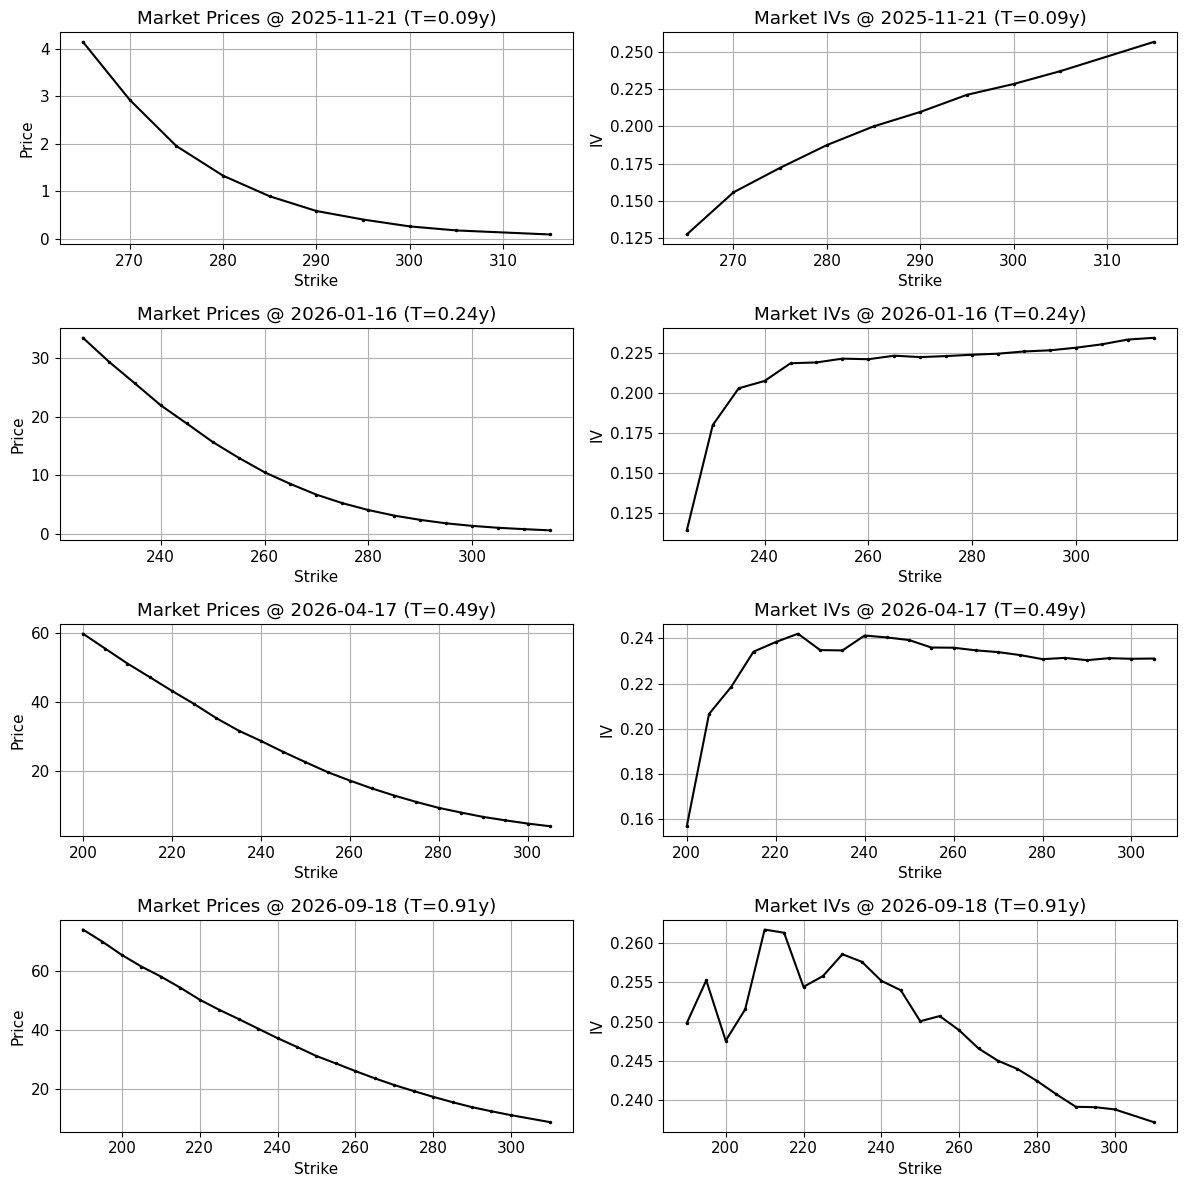

In [48]:
# --- Simple market plots (prices and IVs per expiry) ---
n = len(smiles)
fig, axs = plt.subplots(n, 2, figsize=(12, 3.0*n), sharex=False)
if n==1: axs = np.array([axs])
for i, sm in enumerate(smiles):
    S0, r, q, T = sm['S0'], sm['r'], sm['q'], sm['T']
    K = np.asarray(sm['strikes'], float); mids = np.asarray(sm['mids'], float)
    expiry = sm.get('expiry') or f'T={T:.2f}'
    iv = prices_to_ivs(S0, r, q, T, K, mids, 'call')
    ax = axs[i,0]; ax.plot(K, mids, 'k.-', ms=3); ax.grid(True)
    ax.set_title(f'Market Prices @ {expiry} (T={T:.2f}y)'); ax.set_xlabel('Strike'); ax.set_ylabel('Price')
    ax = axs[i,1]; ax.plot(K, iv, 'k.-', ms=3); ax.grid(True)
    ax.set_title(f'Market IVs @ {expiry} (T={T:.2f}y)'); ax.set_xlabel('Strike'); ax.set_ylabel('IV')
plt.tight_layout()



## 3) Joint calibration across maturities

We calibrate **once** per model using the *entire set of expiries*:

- **Heston** in IV‑space (deterministic & fast).  
- **rBergomi** in IV‑space (MC; vega‑weighted).  
- **Rough Heston** in price‑space (MC; smoother objective).

> *Tip:* For rough models, keep **CRN fixed per expiry**, add **antithetics** and (if you extend) consider **control variates** for faster, smoother fits.


In [49]:
from scipy.optimize import Bounds

# ---- Heston vectorized smile (wrapper to src.heston.heston_smile_prices) ----
try:
    from src.heston import heston_smile_prices as _hsp
except Exception:
    from src.heston import heston_price as _hp
    def _hsp(S0, r, q, T, K, kappa, theta, sigma, v0, rho, N=1536, L=12.0, option='call'):
        return np.array([_hp(S0,Ki,T,r,kappa,theta,sigma,v0,rho,option=option) for Ki in K], float)

def heston_smile_prices(S0, r, q, T, strikes, params, cp="call"):
    kappa, theta, v0, sigma, rho = params
    return _hsp(S0, r, q, T, np.asarray(strikes, float), kappa=kappa, theta=theta, sigma=sigma, v0=v0, rho=rho, option=cp)

# ---- Heston joint calibration (cached; IV-space) ----
short = min(smiles, key=lambda s:s['T'])
atm_idx = int(np.argmin(np.abs(short['strikes']-short['S0'])))
atm_iv  = prices_to_ivs(short['S0'], short['r'], short['q'], short['T'], short['strikes'][atm_idx:atm_idx+1], short['mids'][atm_idx:atm_idx+1])[0]
atm_iv  = float(atm_iv if np.isfinite(atm_iv) else 0.25)

H_BOUNDS = ((1e-4,0.5),(0.05,8.0),(1e-4,0.5),(0.02,2.5),(-0.999,0.999))
h_cfg = dict(cos_N=1536, cos_L=12.0, n_workers=WORKERS)
h_x0  = (max(1e-4,atm_iv**2), 1.5, max(1e-4,atm_iv**2), 0.8, -0.5)

best_h, h_blob = calibrate_heston_cached(
    smiles=smiles_list, metric='iv', vega_weight=True, x0=h_x0, mc=h_cfg,
    seed=None, bounds=H_BOUNDS, multistart=2, options={'maxiter': 180, 'finite_diff_rel_step': 5e-2},
    cache_dir=CACHE_DIR, runtime_overrides=_cache_overrides()
)
params_h = (best_h['kappa'], best_h['theta'], best_h['v0'], best_h['sigma'], best_h['rho'])
print('Heston (joint) best:', best_h, '| elapsed:', h_blob['elapsed_sec'])

# ---- rBergomi joint calibration (IV-space) ----
RB_BOUNDS = ((0.02,0.45),(0.10,3.00),(-0.999,0.0),(0.005,0.25))   # (H,eta,rho,xi0)
rb_cfg = dict(N=256, N_per_year=480, paths=15000, fgn_method="davies-harte", batch_size=8192,  use_numba=True,n_workers=WORKERS)
rb_x0  = (0.12, 1.3, -0.6, 0.04)

best_rb, rb_blob = calibrate_rbergomi_cached(
    smiles_list, metric="iv", vega_weight=True, x0=rb_x0, mc=rb_cfg,
    seed=1234, bounds=RB_BOUNDS, multistart=2, options={"maxiter": 180, "finite_diff_rel_step": 5e-2}
)
print("rBergomi (joint) best:", best_rb, "| elapsed:", rb_blob["elapsed_sec"])

# ---- Rough Heston joint calibration (IV-space) ----
RH_BOUNDS = ((0.005,0.25),(0.2,4.0),(0.005,0.25),(0.1,1.5),(-0.999,-0.01),(0.05,0.35))
rh_cfg = dict(N=256, N_per_year=480, paths=15000, batch_size=2048, use_numba=True)
rh_x0 = (0.06, 1.2, 0.06, 0.6, -0.2, 0.15)  # (v0,kappa,theta,eta,rho,H)

best_rh, rh_blob = calibrate_rough_heston_cached(
    smiles_list, metric="iv", vega_weight=True, x0=rh_x0, mc=rh_cfg,
    seed=7777, bounds=RH_BOUNDS, multistart=2, options={"maxiter": 120, "finite_diff_rel_step": 5e-2}
)
print("Rough Heston (joint) best:", best_rh, "| elapsed:", rh_blob["elapsed_sec"])


[cache hit] heston -> ..\cache\heston\4e93b08d3f79f2c5.json
Heston (joint) best: {'v0': 0.08516614780422935, 'kappa': 0.05, 'theta': 0.5, 'sigma': 0.738632962538275, 'rho': -0.2626672172631319, 'obj': 0.020661827413427692, 'success': True, 'nit': 37, 'history': [{'iter': 1, 'f': 2.3511990636679774, 'df': nan, 'dx': nan, 't': 5.472362041473389, 'dt': 5.472362041473389, 'x': [0.25816658077742705, 0.7749256999798642, 0.25816658077742705, 1.6500871103684351, -0.2823495489651168]}, {'iter': 2, 'f': 1.7824037279915106, 'df': -0.5687953356764668, 'dx': 0.08379919827469233, 't': 8.641318321228027, 'dt': 3.1689562797546387, 'x': [0.23389300615921493, 0.8252058036323006, 0.23750422381228858, 1.5935967440362693, -0.29928814098861256]}, {'iter': 3, 'f': 0.4781517199829415, 'df': -1.304252008008569, 'dx': 0.2378764271808358, 't': 12.108820915222168, 'dt': 3.4675025939941406, 'x': [0.15654907268724802, 0.9619225612566634, 0.1624982445367689, 1.438510300147607, -0.3465526810051382]}, {'iter': 4, 'f':

In [50]:
# ---- Rough Heston rescue: Powell coarse (price) -> L-BFGS-B refine (IV) ----
from concurrent.futures import ThreadPoolExecutor
from scipy.optimize import minimize, Bounds
from src.calibration import _rough_heston_objective

# Prepare price-space data tuples (match _rough_heston_objective signature)
price_dat = []
for sm in smiles:
    strikes = np.asarray(sm['strikes'], float)
    mids = np.asarray(sm['mids'], float)
    price_dat.append((sm['S0'], sm['r'], sm['q'], sm['T'], strikes, mids, sm.get('cp','call'), None))

RH_BOUNDS = ((0.005,0.25),(0.2,4.0),(0.005,0.25),(0.1,1.5),(-0.999,-0.01),(0.05,0.35))
b = Bounds([lo for lo,_ in RH_BOUNDS],[hi for _,hi in RH_BOUNDS])
rh_cfg_coarse = dict(N_per_year=240, N_min=160, paths=8000, batch_size=4096, use_numba=True, n_workers=WORKERS)
with ThreadPoolExecutor(max_workers=WORKERS) as ex:
    obj_price = lambda x: _rough_heston_objective(x, price_dat, 'price', None, rh_cfg_coarse, 7777, ex, True)
    res_pow = minimize(obj_price, x0=np.array(rh_x0, float), method='Powell', bounds=b, options=dict(maxiter=120, xtol=1e-3, ftol=1e-4))
best_rh_coarse = dict(v0=res_pow.x[0], kappa=res_pow.x[1], theta=res_pow.x[2], eta=res_pow.x[3], rho=res_pow.x[4], H=res_pow.x[5], obj=res_pow.fun, success=res_pow.success)
print('RH Powell coarse:', best_rh_coarse)

# Refine (IV metric, L-BFGS-B with absolute eps)
x0_ref = tuple(best_rh_coarse[k] for k in ['v0','kappa','theta','eta','rho','H'])
rh_cfg_ref = dict(N_per_year=480, N_min=256, paths=20000, batch_size=4096, use_numba=True)
best_rh, rh_blob = calibrate_rough_heston_cached(
    smiles_list, metric='iv', vega_weight=True, x0=x0_ref, mc=rh_cfg_ref,
    seed=7777, bounds=RH_BOUNDS, multistart=1, options={'maxiter': 200, 'eps': np.array([6e-3, 2e-1, 6e-3, 5e-2, 2e-2, 1e-2])}
)
print('RH refine best:', best_rh, '| elapsed:', rh_blob['elapsed_sec'])


RH Powell coarse: {'v0': np.float64(0.07666667343303878), 'kappa': np.float64(1.9809019464224649), 'theta': np.float64(0.08066607628225765), 'eta': np.float64(0.636441434125516), 'rho': np.float64(-0.4608197557307235), 'H': np.float64(0.09357162213699649), 'obj': 9.884122105788412, 'success': True}
[RoughHeston #1 start #1] iter=0
[RoughHeston #1] iter=1  f=0.036995  df=nan  |dx|=nan  48.34s
[RoughHeston #1] iter=2  f=0.037003  df=+7.51e-06  |dx|=1.26e-04  161.46s
[RoughHeston #1] iter=3  f=0.037132  df=+1.29e-04  |dx|=5.46e-03  18.19s
[RoughHeston #1] iter=4  f=0.036167  df=-9.65e-04  |dx|=3.03e-03  17.51s
[RoughHeston #1] iter=5  f=0.029441  df=-6.73e-03  |dx|=1.95e-02  16.15s
[RoughHeston #1] iter=6  f=0.027004  df=-2.44e-03  |dx|=1.34e-02  15.76s
[RoughHeston #1] iter=7  f=0.024834  df=-2.17e-03  |dx|=2.82e-02  31.60s
[RoughHeston #1] iter=8  f=0.021151  df=-3.68e-03  |dx|=1.33e-01  15.88s
[RoughHeston #1] iter=9  f=0.021160  df=+8.78e-06  |dx|=1.45e-03  110.35s
[RoughHeston #1] it

In [51]:
# --- Model smile helpers (Heston, rBergomi, Rough Heston) ---
try:
    from src.heston import heston_smile_prices as _hsp
except Exception:
    from src.heston import heston_price as _hp
    def _hsp(S0, r, q, T, K, kappa, theta, sigma, v0, rho, N=1536, L=12.0, option='call'):
        return np.array([_hp(S0,Ki,T,r,kappa,theta,sigma,v0,rho,option=option) for Ki in K], float)

def model_smile_iv_heston(sm):
    S0, r, q, T = sm['S0'], sm['r'], sm['q'], sm['T']
    K = np.asarray(sm['strikes'], float)
    kappa, theta, v0, sigma, rho = params_h
    px = _hsp(S0, r, q, T, K, kappa=kappa, theta=theta, sigma=sigma, v0=v0, rho=rho, option='call')
    iv = prices_to_ivs(S0, r, q, T, K, px, 'call')
    return px, iv

from src.rough import rbergomi_paths, rough_heston_paths

def _N_eff(cfg, T):
    N = int(cfg.get('N', 192))
    Npy = cfg.get('N_per_year', None)
    if Npy is not None:
        try:
            N = max(int(cfg.get('N_min', 128)), int(np.ceil(float(Npy)*float(T))))
        except Exception:
            N = int(cfg.get('N', 192))
    return N

def model_smile_iv_rbergomi(sm, pars, cfg=None, seed=1234):
    if cfg is None:
        cfg = rb_cfg if 'rb_cfg' in globals() else dict(N=256, paths=12000, N_per_year=360)
    S0, r, q, T = sm['S0'], sm['r'], sm['q'], sm['T']
    K = np.asarray(sm['strikes'], float)
    H, eta, rho, xi0 = pars['H'], pars['eta'], pars['rho'], pars['xi0']
    N = _N_eff(cfg, T)
    t, S, _ = rbergomi_paths(S0=S0, T=T, N=N, n_paths=int(cfg.get('paths',12000)), H=H, eta=eta, rho=rho, xi0=xi0, r=r, q=q, seed=seed, fgn_method=cfg.get('fgn_method','davies-harte'))
    ST = S[:,-1]
    DF = np.exp(-r*T)
    payoff = np.maximum(ST[:,None]-K[None,:], 0.0)
    px = DF * payoff.mean(axis=0)
    iv = prices_to_ivs(S0, r, q, T, K, px, 'call')
    return px, iv

def model_smile_iv_rough_heston(sm, pars, cfg=None, seed=7777):
    if cfg is None:
        cfg = rh_cfg if 'rh_cfg' in globals() else dict(N=256, paths=15000, N_per_year=480, batch_size=4096, use_numba=True)
    S0, r, q, T = sm['S0'], sm['r'], sm['q'], sm['T']
    K = np.asarray(sm['strikes'], float)
    v0, kappa, theta, eta, rho, H = pars['v0'], pars['kappa'], pars['theta'], pars['eta'], pars['rho'], pars['H']
    N = _N_eff(cfg, T)
    t, S, _ = rough_heston_paths(S0=S0, v0=v0, T=T, N=N, n_paths=int(cfg.get('paths',15000)), H=H, kappa=kappa, theta=theta, eta=eta, rho=rho, r=r, q=q, seed=seed, batch_size=int(cfg.get('batch_size',4096)), use_numba=cfg.get('use_numba', True))
    ST = S[:,-1]
    DF = np.exp(-r*T)
    payoff = np.maximum(ST[:,None]-K[None,:], 0.0)
    px = DF * payoff.mean(axis=0)
    iv = prices_to_ivs(S0, r, q, T, K, px, 'call')
    return px, iv


In [52]:
# ---- Rough Heston joint calibration (coarse -> refine) ----
# Coarse stage
# rh_cfg1 = dict(N_per_year=240, N_min=160, paths=6000, batch_size=4096, use_numba=True)
# opt1 = {"maxiter": 100, "eps": np.array([5e-3, 2e-1, 5e-3, 5e-2, 2e-2, 1e-2])}
# best_rh_coarse, rh_blob1 = calibrate_rough_heston_cached(
#     smiles_list, metric="iv", vega_weight=True, x0=rh_x0, mc=rh_cfg1,
#     seed=7777, bounds=RH_BOUNDS, multistart=3, options=opt1
# )
# print("Rough Heston (coarse) best:", best_rh_coarse, "| elapsed:", rh_blob1["elapsed_sec"])

# # Refine stage
# rh_cfg2 = dict(N_per_year=480, N_min=256, paths=20000, batch_size=4096, use_numba=True)
# opt2 = {"maxiter": 180, "eps": np.array([3e-3, 1.5e-1, 3e-3, 3e-2, 1.5e-2, 8e-3])}
# x0_ref = tuple(best_rh_coarse[k] for k in ["v0","kappa","theta","eta","rho","H"])
# best_rh_refine, rh_blob2 = calibrate_rough_heston_cached(
#     smiles_list, metric="iv", vega_weight=True, x0=x0_ref, mc=rh_cfg2,
#     seed=7777, bounds=RH_BOUNDS, multistart=1, options=opt2
# )
# print("Rough Heston (refined) best:", best_rh_refine, "| elapsed:", rh_blob2["elapsed_sec"])
# best_rh = best_rh_refine


In [53]:
# --- per-maturity xi0 map for rBergomi using ATM IV scaling ---
xi0_map = {}
H, eta, rho = best_rb['H'], best_rb['eta'], best_rb['rho']
for sm in smiles:
    S0, r, q, T = sm['S0'], sm['r'], sm['q'], sm['T']
    K = np.asarray(sm['strikes'], float)
    mids = np.asarray(sm['mids'], float)
    expiry = sm.get('expiry') or f'T={T:.4f}'
    atm_idx = int(np.argmin(np.abs(K - S0)))
    mkt_atm_iv = prices_to_ivs(S0, r, q, T, K[atm_idx:atm_idx+1], mids[atm_idx:atm_idx+1], 'call')[0]
    t, S, _ = rbergomi_paths(
        S0=S0, T=T, N=rb_cfg['N'], n_paths=rb_cfg['paths'], H=H, eta=eta, rho=rho,
        xi0=best_rb['xi0'], r=r, q=q, seed=12345, fgn_method=rb_cfg.get('fgn_method','davies-harte')
    )
    ST = S[:, -1]
    DF = math.exp(-r * T)
    px_atm = float(np.mean(DF * np.maximum(ST - K[atm_idx], 0.0)))
    mod_atm_iv = prices_to_ivs(S0, r, q, T, np.array([K[atm_idx]]), np.array([px_atm]), 'call')[0]
    if np.isfinite(mod_atm_iv) and mod_atm_iv > 1e-12 and np.isfinite(mkt_atm_iv):
        scale = float(mkt_atm_iv / mod_atm_iv)
        xi_est = float(best_rb['xi0']) * (scale * scale)
        xi0_map[expiry] = float(np.clip(xi_est, 0.005, 0.25))
    else:
        xi0_map[expiry] = float(best_rb['xi0'])
print('rBergomi per-maturity xi0:', xi0_map)


rBergomi per-maturity xi0: {'2025-11-21': 0.11782794302270921, '2026-01-16': 0.08573383796719868, '2026-04-17': 0.08894383061503056, '2026-09-18': 0.09258365477149835}



## 4) Evaluate and plot per‑maturity fits

We compute model prices/IVs for each expiry under the calibrated parameters and report **RMSEs** per maturity and aggregated.


In [54]:
rows=[]
sum_sq = dict(h=0.0, rb=0.0, rh=0.0)
count  = dict(h=0,   rb=0,   rh=0)
for sm in smiles:
    S0,r,q,T,K,mids = sm["S0"],sm["r"],sm["q"],sm["T"],sm["strikes"],sm["mids"]
    mkt_iv = prices_to_ivs(S0,r,q,T,K,mids,"call")

    px_h, iv_h   = model_smile_iv_heston(sm)
    px_rb, iv_rb = model_smile_iv_rbergomi(sm, best_rb)
    px_rh, iv_rh = model_smile_iv_rough_heston(sm, best_rh)

    def rmse(a,b):
        a,b=np.asarray(a,float), np.asarray(b,float)
        return float(np.sqrt(np.nanmean((a-b)**2)))

    rows.append(dict(expiry=sm["expiry"], T=T,
                     rmse_px_h=rmse(px_h,mids), rmse_iv_h=rmse(iv_h,mkt_iv),
                     rmse_px_rb=rmse(px_rb,mids), rmse_iv_rb=rmse(iv_rb,mkt_iv),
                     rmse_px_rh=rmse(px_rh,mids), rmse_iv_rh=rmse(iv_rh,mkt_iv)))

    # accumulate global IV RMSE pieces (unweighted by vega; weighted by count)
    m_h  = np.isfinite(iv_h)  & np.isfinite(mkt_iv)
    m_rb = np.isfinite(iv_rb) & np.isfinite(mkt_iv)
    m_rh = np.isfinite(iv_rh) & np.isfinite(mkt_iv)
    if m_h.any():
        sum_sq['h']  += float(np.nansum((iv_h[m_h]-mkt_iv[m_h])**2)); count['h']  += int(np.sum(m_h))
    if m_rb.any():
        sum_sq['rb'] += float(np.nansum((iv_rb[m_rb]-mkt_iv[m_rb])**2)); count['rb'] += int(np.sum(m_rb))
    if m_rh.any():
        sum_sq['rh'] += float(np.nansum((iv_rh[m_rh]-mkt_iv[m_rh])**2)); count['rh'] += int(np.sum(m_rh))

res = pd.DataFrame(rows).sort_values("T")
display(res)

# Weighted global IV RMSE by valid quote count
g_h  = float(np.sqrt(sum_sq['h']  / max(1, count['h'])))
g_rb = float(np.sqrt(sum_sq['rb'] / max(1, count['rb'])))
g_rh = float(np.sqrt(sum_sq['rh'] / max(1, count['rh'])))
print(f"Global RMSE (IV): Heston= {g_h:.6f}  rBergomi= {g_rb:.6f}  RoughHeston= {g_rh:.6f}")


,expiry,T,rmse_px_h,rmse_iv_h,rmse_px_rb,rmse_iv_rb,rmse_px_rh,rmse_iv_rh
0,2025-11-21,0.087671,0.364698,0.034778,0.260582,0.010702,0.426496,0.021417
1,2026-01-16,0.241096,0.638764,0.024271,0.778329,0.029146,0.352957,0.011281
2,2026-04-17,0.490411,0.506772,0.016161,1.138811,0.033430,0.588416,0.010607
3,2026-09-18,0.912329,1.025496,0.012805,1.189197,0.018608,0.794144,0.014658


Global RMSE (IV): Heston= 0.020966  rBergomi= 0.025576  RoughHeston= 0.014043


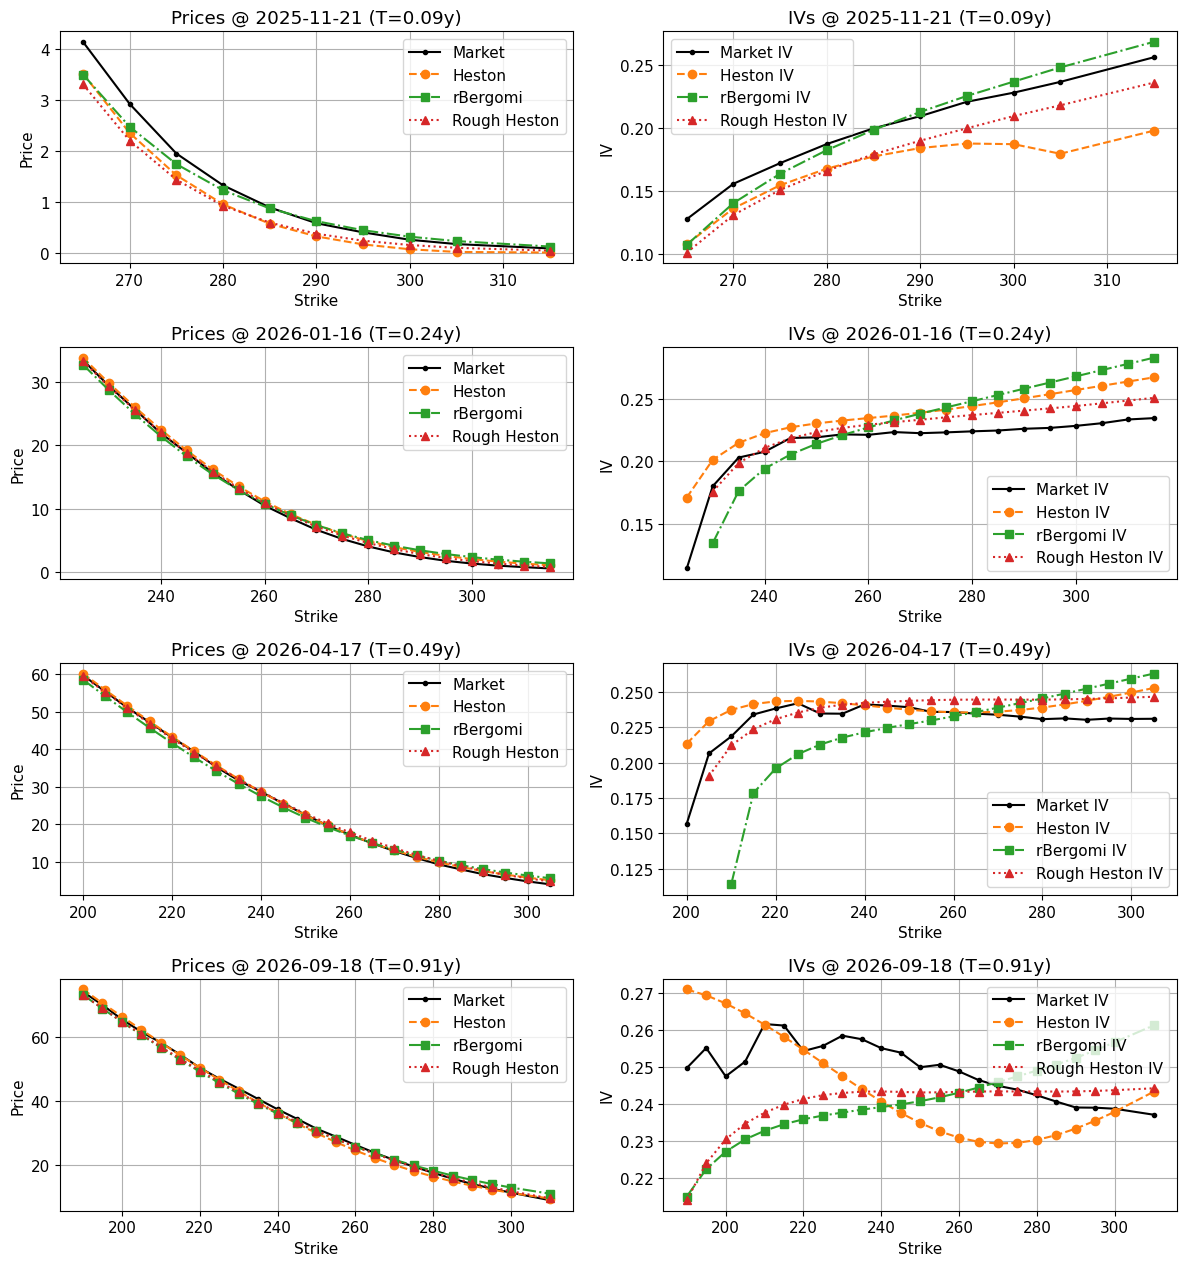

In [55]:
# Plot one figure per expiry comparing Market vs all three models (IVs)
n = len(smiles)
fig, axs = plt.subplots(n, 2, figsize=(12, 3.2*n), sharex=False)
if n==1: axs = np.array([axs])  # shape (1,2)
for i, sm in enumerate(smiles):
    S0,r,q,T = sm['S0'], sm['r'], sm['q'], sm['T']
    K = np.asarray(sm['strikes'], float)
    mids = np.asarray(sm['mids'], float)
    expiry = sm.get('expiry') or f'T={T:.2f}'
    # model smiles
    px_h, iv_h   = model_smile_iv_heston(sm)
    px_rb, iv_rb = model_smile_iv_rbergomi(sm, best_rb)
    px_rh, iv_rh = model_smile_iv_rough_heston(sm, best_rh)
    mkt_iv = prices_to_ivs(S0, r, q, T, K, mids, 'call')
    # prices
    ax = axs[i,0]
    ax.plot(K, mids, 'k.-', label='Market')
    ax.plot(K, px_h, 'C1o--', label='Heston')
    ax.plot(K, px_rb, 'C2s-.', label='rBergomi')
    ax.plot(K, px_rh, 'C3^:', label='Rough Heston')
    ax.set_title(f'Prices @ {expiry} (T={T:.2f}y)')
    ax.set_xlabel('Strike'); ax.set_ylabel('Price'); ax.legend()
    # IVs
    ax = axs[i,1]
    ax.plot(K, mkt_iv, 'k.-', label='Market IV')
    ax.plot(K, iv_h, 'C1o--', label='Heston IV')
    ax.plot(K, iv_rb, 'C2s-.', label='rBergomi IV')
    ax.plot(K, iv_rh, 'C3^:', label='Rough Heston IV')
    ax.set_title(f'IVs @ {expiry} (T={T:.2f}y)')
    ax.set_xlabel('Strike'); ax.set_ylabel('IV'); ax.legend()
plt.tight_layout()



## 5) Tips & Extensions

- **Variance reduction (MC)**: use **antithetic** normals and a **control variate** (e.g., Black–Scholes) for vanillas to reduce noise drastically.
- **Common Random Numbers (CRN)**: keep RNG seeds **fixed per expiry** inside the objective for smoother calibrations.
- **Grid \(H\)**: fix or grid \(H\in\{0.06,0.10,0.14,0.20\}\), calibrate other params, then pick the best — stabilizes rough models.
- **Weights**: vega-weight in IV-space; down-weight deep wings (low vegas).
- **Parallelize**: run multistarts in parallel; batch MC to utilize BLAS threads.
- **Deterministic rough pricing**: for Rough Heston, explore **fractional Riccati / CF** (El Euch & Rosenbaum) for Heston-like speed.
